### Table of Contents

* [Functions](#Functions)
* [Exploratory, Data Preprocessing](#Exploratory)
* [Processing Data](#ProcessingData)
    * [Applying Clean Up](#ApplyCleanup)
    * [Examine Cleaned Twweets](#CleanedTweets)
    * [Observations](#VisByCountObservations)
    * [Tokeninzing & Indexing](#Tokenizing)
    * [Create Embedded Matrix](#embeddedMatrix)
    * [Examing OOV](#OOV)
* [Train Test SPlit - Stratify, Create TFIDF](#traintestsplit)
    * [Calculate Class Weights](#classweights)
    * [Perform Smote](#smoted)
    * [Scale](#scaled)
* [Create Models](#Models)
    * [RNN](#RNN)
    * [View Results/ Confusion Matrix](#RNNMatrix)
    * [Simple ML Models](#)
    * [Bayes](#bayes)
    * [View Results/ Confusion Matrix](#BayesMatrix)
    * [RF](#SVM)
    * [View Results/ Confusion Matrix](#SVMMatrix)
* [Conclusions](#Conclusions)    
* [Create Pickle Files For Modeling](#CreatePickle)   

In [1]:
# # # download pre-trained vectors trained on twitter data
# download.file("http://nlp.stanford.edu/data/glove.twitter.27B.zip", destfile = "glove.zip")
# unzip("glove.zip", exdir = "E:/Downloads/GLOVE")
import pandas as pd
import numpy as np
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
import pickle

import spacy
nlp = spacy.load("en_core_web_lg")
from nltk.tokenize import TweetTokenizer

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import itertools
from spellchecker import SpellChecker


from IPython.display import Markdown, display

from tqdm import tqdm
# tqdm.pandas()

import string
import operator 
import re
from textblob import TextBlob
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import gc
import keras
plt.style.use('fivethirtyeight')



# define model
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional, SpatialDropout1D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dropout
from keras.initializers import Constant
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


import warnings
warnings.filterwarnings("ignore")

from gensim.models import word2vec
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import KeyedVectors


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

#glove2word2vec(glove_input_file=PTrVec_twitterPath, word2vec_output_file="gensim_glove_vectors.txt")

pd.set_option("max_rows", 1000)
pd.set_option('display.width', None)
pd.set_option('max_columns', None)
pd.set_option('max_colwidth', 200)

In [2]:
df_data_O = pd.read_csv("./data/judge-1377884607_tweet_product_company.csv", engine='python')
#df_data = pd.read_csv("./data/Russ.csv", engine='python')

#encoding='utf-8'
# encoding = "cp1252"
# encoding = "ISO-8859-1"
# encoding='utf-8'

# Functions <a class="anchor" id="Functions"></a>

## Misc

In [51]:
def build_vocab(texts):
    sentences = texts.apply(lambda x: x.split()).values
    vocab = {}
    for sentence in sentences:
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

def createEmbeddedMatrix (name, vocab_size, embedding_dim, embeddings_index):
    '''this function takes in the vocab size of your corpus or #of unique and the size of the vector representing
    your pretrained vector - 100 or 300 in our examples, and the actual pretrained vector indexed by word'''
    skippedwords = 0
    hits = 0

    # Creating container for embedding
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    # get vectors for words that are present in both my vocab and the pretrained word2vec
    if name == "RNN":
        for word, i in t_RNN.word_index.items():
            try:
                embedding_vector = embeddings_index[word]
            except:
                skippedwords = skippedwords+1
                pass
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                hits += 1
        print("Converted %d words (%d misses)" % (hits, skippedwords))
        
    elif name == "TFIDF":
        for word, i in t_tfidf.word_index.items():
            try:
                embedding_vector = embeddings_index[word]
            except:
                skippedwords = skippedwords+1
                pass
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                hits += 1
        print("Converted %d words (%d misses)" % (hits, skippedwords))
    return embedding_matrix

def plot_history(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    

def getmaxlength(encoded_docs):
    max_length = 0
    for review_number in range(len(encoded_docs)):
        nuumberofwords=len(encoded_docs[review_number])
        if (nuumberofwords) > (max_length):
            max_length = nuumberofwords
    return max_length


def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
    return  TextBlob(text).sentiment.polarity




# Create a function to compute negative (-1), neutral (0) and positive (+1) analysis
def getAnalysis(score):
    if score < 0:
        #No emotion toward brand or product
        return 'Negative'
    elif score == 0:
        return 'Neutral'
        #Positive emotion
    else:
        return 'Positive'


def check_coverage(name, index, vocab, embeddings_index):
    known_words = {}
    unknown_words = {}
    nb_known_words = 0
    nb_unknown_words = 0
    for word in vocab.keys():
        try:
            known_words[word] = embeddings_index[word]
            nb_known_words += vocab[word]
        except:
            unknown_words[word] = vocab[word]
            nb_unknown_words += vocab[word]
            pass
    print(f'{name} : {index}')
    print('Found embeddings for {:.3%} of vocab'.format(len(known_words) / len(vocab)))
    print('Found embeddings for  {:.3%} of all text'.format(nb_known_words / (nb_known_words + nb_unknown_words)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]

    return unknown_words

def getCOuntsofPredictedScores(predictions_model):
    """takes in array from .predict() and counts the labels for each class via the model"""
    unique, counts = np.unique(predictions_model, return_counts=True)
    return dict(zip(unique, counts))

def set_weights(y_train, weight = 'balanced', return_class = False, verbose = True):
    """Compute class weights for a given target column. Generate array of sample 
    weights. Optionally, prints a preview of the generated weights and classes.
    Args:
        y_train (list or Series): The target/class data for model.
        weight (str): Type of class balancing to calculate. Defaults to 'balanced'.
        return_class (bool, optional): Whether to return class weights also. 
                                        Defaults to False.
        verbose (bool, optional): Prints dict of classes and weights, previews 
                                        sample weights. Defaults to True.
    Returns:
        np.array: Array of sample weights, one per sample in y_train.
        dict (optional) : keys = classes in target, values = weights
    """
    # Calculate weight per class based upon a specificed distribution of target classes
    class_weights = class_weight.compute_class_weight(class_weight = weight, 
                                                    classes = np.unique(y_train), 
                                                    y = y_train)

    c_weights_dict = dict(zip(np.unique(y_train), class_weights))
    
    # Assign associated class weight to each sample, returns an array of sample length
    sample_weights = class_weight.compute_sample_weight(c_weights_dict, y = y_train)

    if verbose:

        print("Class Weights:", len(class_weights), "classes")
        display(c_weights_dict)

        print("Sample Weights:", len(sample_weights), "samples")
        display(sample_weights)

    if return_class:

        return class_weights, sample_weights
    
    else:

        return sample_weights

# def tweetTokenizer1(listofTweets):
#     tweet_tokenizer = TweetTokenizer()
#     tweet_tokens = []
#     for sent in listofTweets:
# #         print(tweet_tokenizer.tokenize(sent))
#         tweet_tokens.append(tweet_tokenizer.tokenize(sent))
#     return tweet_tokens
    
    
    
def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()])
    wordcloud = WordCloud(
                      background_color=color,
                      width=2500,
                      height=1500
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(10, 10))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
    
def plot_confusion_matrix(nameOfMatrix, cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print(f'{nameOfMatrix} - Normalized confusion matrix here')
    else:
        print(f'{nameOfMatrix} - Confusion matrix, without normalization')

 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    # Idont think I need ______________________________________________
from sklearn.preprocessing import OneHotEncoder
def prepare_inputs(X_train, X_test):
    ohe = OneHotEncoder()
    ohe.fit(X_train)
    X_train_enc = ohe.transform(X_train)
    X_test_enc = ohe.transform(X_test)
    return X_train_enc, X_test_enc

from sklearn.preprocessing import LabelEncoder
def prepare_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_test_enc


def CreateEmeddingManuallyFor_twitter():
    embeddings_index_twitter = {}
    PTrVec_twitterPath = 'C:\\Users\\rgpih\\Documents\\NLPCourseDeepLearning\\JupyterNotebook\\large_files\\glove.twitter.27B.200d.txt'
    embeddings_index_twitter = {}
    with open(PTrVec_twitterPath, encoding="utf8") as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index_twitter[word] = coefs
    print("Found %s word vectors." % len(embeddings_index_twitter))
    return embeddings_index_twitter



def getlenofvectorsInEmbedding_Index(embeddings_index):
    '''This function takes in the dict from the pretrained vec, each key is the word and the value is the vector 
    representing the word created by the pretrained model, uses the first word to get the length of the vector
    this number is required to create the deep learning embedded layer '''
    values_view = embeddings_index.values()
    value_iterator = iter(values_view)
    first_value = next(value_iterator)
    return len(first_value)
# Idont think I need ______________________________________________

## Cleaning Up <a class="anchor" id="CleanupFunctions"></a>

In [4]:
# https://towardsdatascience.com/effectively-pre-processing-the-text-data-part-1-text-cleaning-9ecae119cb3e
#https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings
#https://mlwhiz.com/blog/2019/01/17/deeplearning_nlp_preprocess/


spell = SpellChecker()
#https://towardsdatascience.com/pre-trained-word-embedding-for-text-classification-end2end-approach-5fbf5cd8aead
#https://medium.com/prevision-io/automated-nlp-with-prevision-io-part1-naive-bayes-classifier-475fa8bd73de

def correct_spellings(x, spell=spell):
    """correct the missplled words of a given tweet"""
    x = x.split()
    misspelled = spell.unknown(x)
    result = map(lambda word : spell.correction(word) if word in  misspelled else word, x)
    return " ".join(result)


def tweets_cleaning(x, correct_spelling=True, remove_emojis=True):
    """Apply function to a clean a tweet"""
#     x = x.lower().strip()
#     # romove urls
#     url = re.compile(r'https?://\S+|www\.\S+')
#     x = url.sub(r'',x)
#     # remove html tags
#     html = re.compile(r'<.*?>')
#     x = html.sub(r'',x)
#     # remove punctuation
#     operator = str.maketrans('','',string.punctuation) #????
#     x = x.translate(operator)
    if correct_spelling:
        x = correct_spellings(x)
    if remove_emojis:
        x = x.encode('ascii', 'ignore').decode('utf8').strip()
#     if remove_stop_words:
#         x = ' '.join([word for word in x.split(' ') if word not in stop_words])
    return x




# #remove infrequenct words
# texts = train['text'].to_numpy()
# word_freq = {}

# for text in texts:
#     for word in text.split():
#         word_freq[word] = word_freq.get(word, 0) + 1
# # # remove words occuring < 3 times
# # freq_threshold = 3
# # for i, text in enumerate(texts):
# #     for word in text.split():
# #         if word_freq[word] < freq_threshold:
# #             print(word)
# #             texts[i].replace(word, '')



def clean(text):
    text = text.split("/")
    text = ' '.join([str(elem) for elem in text])
    text = re.sub('@[A-Za-z0–9]+', '', text) #Removing @mentions
    #text = re.sub('["#%\'()+,-.:;<=>^_`{|}~*]', '', text) # Removing
    text = re.sub('[?!.,"#$%\'()*+-/:;<=>@[\\]^_`{|}~]', '', text) # Removing
    text = re.sub('[""]', '', text) # Removing
    text = re.sub('[‰Û÷]', '', text) # Removing 
    text = re.sub('[/\&]', ' ', text) # 
    text = re.sub('(SXSW).[^\s]*', ' ', text) # Removing the entire word if contains "SXSW"
    text = re.sub('(sxsw).[^\s]*', ' ', text) # Removing the entire word if contains "sxsw"
    #text = re.sub('#', '', text) # Removing '#' hash tag
    text = re.sub('RT[\s]+', '', text) # Removing RT
    text = re.sub('https?:\/\/\S+|www\\.\S+', '', text) # Removing hyperlink
    text = re.sub('(quot)', '', text) # Removing hyperlink
    text = re.sub('(amp)', '', text) # Removing hyperlink
    text = re.sub('(infektd)', '', text) # Removing hyperlink
    text = text.split("\\")
    text = ' '.join([str(elem) for elem in text])
    text = text.split("_")
    text = ' '.join([str(elem) for elem in text])
    return text



def clean_numbers(x):

    x = re.sub('[0-9]{5,}', '', x)
    x = re.sub('[0-9]{4}', '', x)
    x = re.sub('[0-9]{3}', '', x)
    x = re.sub('[0-9]{2}', '', x)
    return x


def RemovesGarbageWords(text):
    listofgarbagewords = ['sxsw','http' , 'a','to','of','and','quot', 
                       'tapworthy', "qagb","gsdm", "musedchat","newTwitter"]
    listofgarbagewords = ' '.join([i for i in text.split() if i.lower() not in listofgarbagewords])

    return listofgarbagewords

def RemoveStopwords(text):
    stop_free = ' '.join([i for i in text.split() if i not in stop_words])
    return stop_free


def lemmatization(texts):
# allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        #put in raw text, and get back a Doc object, that comes with a variety of annotations.
        doc = nlp(" ".join(sent))  
        #using spacey to lemmatize
        texts_out.append([token.lemma_ for token in doc])
#         if token.pos_ in allowed_postags
    return texts_out


def lemmatization1(texts):
# allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']

#     print("here")
#     print(texts)
    texts_out = []
    doc = nlp(texts)
# #     print(doc) 
    #using spacey to lemmatize
    texts_out.append([token.lemma_ for token in doc])
    listToStr = ' '.join([str(elem) for elem in texts_out[0]])
    return listToStr

mispell_dict = {'doesnt':'does not',
                    'instagram': 'social medium',
                    'whatsapp': 'social medium',
                    'snapchat': 'social medium'}

def tolower(text):
    tolower = ' '.join([i.lower() for i in text.split()])
    return tolower

# Show the new dataframe with columns 'Subjectivity' & 'Polarity'
# Create a function to get the subjectivity


#     Negative emotion
#     I can't tell

# # Printing positive tweets 
# print('Printing positive tweets:\n')
# j=1
# sortedDF = df.sort_values(by=['Polarity']) #Sort the tweets
# for i in range(0, sortedDF.shape[0] ):
#   if( sortedDF['Analysis'][i] == 'Positive'):
#     print(str(j) + ') '+ sortedDF['Tweets'][i])
#     print()
#     j= j+1

# Print the percentage of positive tweets
# ptweets = df[df.Analysis == 'Positive']
# ptweets = ptweets['Tweets']
# ptweets

# round( (ptweets.shape[0] / df.shape[0]) * 100 , 1)

def tweetTokenizer(listofTweets):
    tweet_tokenizer = TweetTokenizer()
    tweet_tokens = []
    for sent in listofTweets:
#         print(tweet_tokenizer.tokenize(sent))
        tweet_tokens.append(tweet_tokenizer.tokenize(sent))
    return tweet_tokens


def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re

mispellings, mispellings_re = _get_mispell(mispell_dict)
def replace_typical_misspell(text):
    def replace(match):
        return mispellings[match.group(0)]
    return mispellings_re.sub(replace, text)

def correct_spelling(x):
    
    dic = {'doesnt':'does not',
                    'instagram': 'social medium',
                    'whatsapp': 'social medium',
                    'snapchat': 'social medium'}

    
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

contraction_dict = {"didnt":"did not", "ain't": "is not", "aren't": "are not","can't": 
                    "cannot", "'cause": "because", "could've": "could have", 
                    "couldn't": "could not", "didn't": "did not",  
                    "doesn't": "does not", "don't": "do not", 
                    "hadn't": "had not", "hasn't": "has not", 
                    "haven't": "have not", "he'd": "he would","he'll": 
                    "he will", "he's": "he is", "how'd": "how did", 
                    "how'd'y": "how do you", "how'll": "how will", 
                    "how's": "how is",  "I'd": "I would", "I'd've": 
                    "I would have", "I'll": "I will", "I'll've": 
                    "I will have","I'm": "I am", "I've": 
                    "I have", "i'd": "i would", "i'd've": 
                    "i would have", "i'll": "i will",  "i'll've": 
                    "i will have","i'm": "i am", "i've": "i have", 
                    "isn't": "is not", "it'd": "it would", "it'd've": 
                    "it would have", "it'll": "it will", "it'll've": 
                    "it will have","it's": "it is", "let's": "let us", 
                    "ma'am": "madam", "mayn't": "may not", "might've": 
                    "might have","mightn't": "might not","mightn't've": 
                    "might not have", "must've": "must have", "mustn't": 
                    "must not", "mustn't've": "must not have", "needn't": 
                    "need not", "needn't've": "need not have","o'clock": 
                    "of the clock", "oughtn't": "ought not", "oughtn't've": 
                    "ought not have", "shan't": "shall not", "sha'n't": 
                    "shall not", "shan't've": "shall not have", "she'd": 
                    "she would", "she'd've": "she would have", "she'll": 
                    "she will", "she'll've": "she will have", "she's": 
                    "she is", "should've": "should have", "shouldn't": 
                    "should not", "shouldn't've": "should not have", "so've": 
                    "so have","so's": "so as", "this's": "this is","that'd": 
                    "that would", "that'd've": "that would have", "that's": 
                    "that is", "there'd": "there would", "there'd've": "there would have", 
                    "there's": "there is", "here's": "here is","they'd": "they would", 
                    "they'd've": "they would have", "they'll": "they will", "they'll've": 
                    "they will have", "they're": "they are", "they've": "they have", "to've":
                    "to have", "wasn't": "was not", "we'd": "we would",
                    "we'd've": "we would have", "we'll": "we will", "we'll've": 
                    "we will have", "we're": "we are", "we've": "we have",
                    "weren't": "were not", "what'll": "what will",
                    "what'll've": "what will have", "what're": "what are",  
                    "what's": "what is", "what've": "what have", 
                    "when's": "when is", "when've": "when have", 
                    "where'd": "where did", "where's": "where is",
                    "where've": "where have", "who'll": "who will",
                    "who'll've": "who will have", "who's": "who is",
                    "who've": "who have", "why's": "why is", "why've": 
                    "why have", "will've": "will have", "won't": 
                    "will not", "won't've": "will not have", "would've": 
                    "would have", "wouldn't": "would not", "wouldn't've": 
                    "would not have", "y'all": "you all", "y'all'd": 
                    "you all would","y'all'd've": "you all would have","y'all're":
                    "you all are","y'all've": "you all have","you'd": "you would", 
                    "you'd've": "you would have", "you'll": "you will", "you'll've": 
                    "you will have", "you're": "you are", "you've": "you have"}

def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re

contractions, contractions_re = _get_contractions(contraction_dict)

def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

def add_lower(embedding, vocab):
    count = 0
    for word in vocab:
        if word in embedding and word.lower() not in embedding:  
            embedding[word.lower()] = embedding[word]
            count += 1
    print(f"Added {count} words to embedding")



# Exploratory, Data Processing <a class="anchor" id="Exploratory"></a>

## Exploratory

In [5]:
df_data_O.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion


In [6]:
len(df_data_O)

9093

In [7]:
#Rename columns
df_data_O.columns = ["tweets", "Prd_Brnd", "emotion"]

In [8]:
# set target to numericals
di = {"No emotion toward brand or product":1, "Positive emotion":2, "Negative emotion":0,"I can't tell":3}
df_data_O['emotion_E'] = df_data_O['emotion']
df_data_O['emotion_E'].replace(di, inplace=True)

In [9]:
# df_data = df_data_O[~df_data_O["emotion"].str.contains("I can't tell")].copy()
df_data_O = df_data_O.query("emotion_E not in [3]")

In [10]:
max_sent_length = min(df_data_O["emotion"].apply(len).max(), 25)
#df_no = df_data[df_data["emotion_E"]==1]

In [11]:
df_data_O.describe(include='all')

,tweets,Prd_Brnd,emotion,emotion_E
count,8936,3282,8937,8937.000000
unique,8909,9,3,NaN
top,RT @mention Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #sxsw,iPad,No emotion toward brand or product,NaN
freq,5,942,5389,NaN
mean,NaN,NaN,NaN,1.269442
std,NaN,NaN,NaN,0.569595
min,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,1.000000
50%,NaN,NaN,NaN,1.000000
75%,NaN,NaN,NaN,2.000000


In [12]:
df_data_O["Prd_Brnd"].value_counts()

iPad                               942
Apple                              659
iPad or iPhone App                 470
Google                             429
iPhone                             296
Other Google product or service    292
Android App                         81
Android                             78
Other Apple product or service      35
Name: Prd_Brnd, dtype: int64

In [13]:
df_data_O.emotion.value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
Name: emotion, dtype: int64

In [14]:
df_data_O.isnull().sum()

tweets          1
Prd_Brnd     5655
emotion         0
emotion_E       0
dtype: int64

In [15]:
#drop rows that are null based on value in tweet field
df_data1 = df_data_O.dropna(subset=['tweets'])
# df_data = df_data.dropna(inplace = True)
# df_data1 = df_data_O.dropna()
df_data1.reset_index(inplace=True)
df_data1.drop(columns=["index"], inplace=True)
df_data = df_data1.copy()

In [16]:
blanks = []  # start with an empty list

for i,lb,rv in df_data[["emotion","tweets"]].itertuples():  # iterate over the DataFrame
    if type(rv)==str:            # avoid NaN values
        if rv.isspace():         # test 'review' for whitespace
            blanks.append(i)     # add matching index numbers to the list
        
print(len(blanks), 'blanks: ', blanks)

df_data.drop(blanks, inplace=True)

0 blanks:  []


In [17]:
df_data.emotion.value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
Name: emotion, dtype: int64

In [18]:
df_nuetral = df_data[df_data["emotion_E"]==1]
df_pos = df_data[df_data["emotion_E"]==2]
df_neg = df_data[df_data["emotion_E"]==0]

print("df_neg")
print(df_neg.Prd_Brnd.value_counts())
print("\n")
print("Neutral")
print(df_nuetral.Prd_Brnd.value_counts())
print("\n")
print("Pos")
print(df_pos.Prd_Brnd.value_counts())

df_neg
iPad                               125
iPhone                             103
Apple                               95
Google                              68
iPad or iPhone App                  63
Other Google product or service     47
Android                              8
Android App                          8
Other Apple product or service       2
Name: Prd_Brnd, dtype: int64


Neutral
iPad                               24
Apple                              21
Google                             15
iPad or iPhone App                 10
iPhone                              9
Other Google product or service     9
Android App                         1
Other Apple product or service      1
Android                             1
Name: Prd_Brnd, dtype: int64


Pos
iPad                               793
Apple                              543
iPad or iPhone App                 397
Google                             346
Other Google product or service    236
iPhone                         

# Processing Data <a class="anchor" id="ProcessingData"></a>

## Applying Cleanup Functions & Preprocessing Steps <a class="anchor" id="ApplyCleanup"></a>

In [19]:
#Print imbalance
from collections import Counter
values = Counter(df_data['emotion_E'])
print(values.get(0)/len(df_data['emotion_E']))
print(values.get(1)/len(df_data['emotion_E']))
print(values.get(2)/len(df_data['emotion_E']))

0.06378692927484333
0.6029543419874664
0.33325872873769025


In [20]:
#One-hot encode the emotion
labels_RNN = to_categorical(df_data['emotion_E'], num_classes=3)

labels_dct = {"label_RNN":[]}
for i in labels_RNN:
    labels_dct["label_RNN"].append(i)
    
df_labels_RNN = pd.DataFrame.from_dict(labels_dct)
    
df_data["Labels_RNN"] = df_labels_RNN

In [21]:
# Clean the tweets
df_data["tweets_RNN"] = df_data['tweets'].apply(replace_contractions)
df_data["tweets_RNN"] = df_data['tweets_RNN'].apply(clean)
df_data["tweets_RNN"] = df_data['tweets_RNN'].apply(RemovesGarbageWords)

# prepare tweets for word2vec/ glove/ embeddings - RNN/ LSTM model
df_data["tweets_RNN"] = df_data['tweets_RNN'].apply(clean_numbers)
df_data["tweets_RNN"] = df_data['tweets_RNN'].apply(replace_typical_misspell)
# df_data["tweets_RNN_SP"] = df_data['tweets_RNN'].apply(correct_spelling)

test = tweets_cleaning("jek is a test")

# df_data["tweets_RNN"] = df_data['tweets_RNN'].apply(tweets_cleaning)

# prepare tweets for tf-idf vector creation using NLP()
df_data["tweets_tfid"] = df_data['tweets_RNN'].apply(tolower)
df_data["tweets_tfid"] = df_data['tweets_tfid'].apply(RemoveStopwords)
df_data["tweets_tfid"] = df_data['tweets_tfid'].apply(lemmatization1)


#Create two new columns : 'Subjectivity' & 'Polarity'
df_data['Subjectivity'] = df_data['tweets_RNN'].apply(getSubjectivity)
df_data['Polarity'] = df_data['tweets_RNN'].apply(getPolarity)
# df['Analysis'] = df['Polarity'].apply(getAnalysis)

## Examine Cleaned Tweets <a class="anchor" id="CleanedTweets"></a>

In [76]:
# https://github.com/nagypeterjob/Sentiment-Analysis-NLTK-ML-LSTM/blob/master/Sentiment.ipynb

# view positive and negative words
train_pos = df_data[ df_data['emotion_E'] == '2']
train_pos = df_data['tweets_RNN']
train_neg = df_data[ df_data['emotion_E'] == '0']
train_neg = df_data['tweets_RNN']
train_neut = df_data[ df_data['emotion_E'] == '1']
train_neut = df_data['tweets_RNN']

    
# print("Positive words")
# wordcloud_draw(train_pos,'white')
# print("Negative words")
# wordcloud_draw(train_neg)
# print("Neutral words")
# wordcloud_draw(train_neut)

In [68]:
# get count of vocabulary words - TF-IDF
vocab_tfid = build_vocab(df_data["tweets_tfid"])
reviewVocab_TFID = sorted(vocab_tfid.items(), key=lambda x: x[1], reverse=True)
reviewVocab_TFID[:10]

[('link', 3543),
 ('google', 2519),
 ('ipad', 2466),
 ('apple', 2071),
 ('iphone', 1507),
 ('store', 1470),
 ('2', 1082),
 ('new', 1078),
 ('app', 990),
 ('austin', 929)]

In [69]:
# get count of vocabulary words - RNN
vocab_RNN = build_vocab(df_data["tweets_RNN"])
reviewVocab_word2Vec = sorted(vocab_RNN.items(), key=lambda x: x[1], reverse=True)
reviewVocab_word2Vec[:10]

[('the', 3853),
 ('link', 3526),
 ('at', 2791),
 ('for', 2371),
 ('iPad', 2076),
 ('Google', 1907),
 ('is', 1810),
 ('in', 1775),
 ('Apple', 1622),
 ('I', 1388)]

In [25]:
# # Finding if tweets contain a word - Used for future additionalcleaning
# df_find = df_data[df_data["tweets"].str.contains('2')]
# df_find

## Tokenizing & Indexing <a class="anchor" id="Tokenizing"></a>

In [26]:
#https://www.youtube.com/watch?v=2EiA_TA2NJo

## Tokenize the sentences for RNN
t_RNN = Tokenizer()
#Corpus Split into lists of tokens. They will then be indexed and vectorized
t_RNN.fit_on_texts(df_data["tweets_RNN"])
vocab_size_RNN = len(t_RNN.word_index) + 1
# convert actual reviews from list of strings to lists of integers

encoded_docs = t_RNN.texts_to_sequences(df_data["tweets_RNN"])


t_tfidf = Tokenizer()
t_tfidf.fit_on_texts(df_data["tweets_tfid"])
vocab_size_tfidf = len(t_tfidf.word_index) + 1

## Get and Create Embedded Representation <a class="anchor" id="embeddedMatrix"></a>

In [27]:
#Create word indexes from scratch
# PTrVec_GooglePath = 'C:\\Users\\rgpih\\Documents\\NLPCourseDeepLearning\\JupyterNotebook\\large_files\\GoogleNews-vectors-negative300.bin'
# embeddings_index_google = KeyedVectors.load_word2vec_format(PTrVec_GooglePath, binary=True)
# embeddings_index_twitter = KeyedVectors.load_word2vec_format("gensim_glove_vectors.txt", binary=False)

#Create pickel files - Google
# # open a file, where you ant to store the data
# file = open('embeddings_index_google', 'wb')
# # dump information to that file
# pickle.dump(embeddings_index_google, file)

# # #Create pickel files - twitter
# # open a file, where you ant to store the data
# file = open('embeddings_index_twitter', 'wb')
# # dump information to that file
# pickle.dump(embeddings_index_twitter, file)

with open('..\embeddings_index_google', 'rb') as f:
    embeddings_index_google = pickle.load(f)
with open('..\embeddings_index_twitter', 'rb') as f:
    embeddings_index_twitter = pickle.load(f)

# get the lenght of each index, passed into RNN models
embedding_dim_twitter = len(embeddings_index_twitter['the'])
embedding_dim_google = len(embeddings_index_google['the'])



### Creating Embedding Matrix For Words In Vocab

In [28]:
embedding_matrix_twitter_RNN = createEmbeddedMatrix("RNN", vocab_size_RNN, embedding_dim_twitter,embeddings_index_twitter)
embedding_matrix_google_RNN = createEmbeddedMatrix("RNN", vocab_size_RNN, embedding_dim_google,embeddings_index_google)

embedding_matrix_twitter_TFIDF = createEmbeddedMatrix("TFIDF", vocab_size_tfidf, embedding_dim_twitter,embeddings_index_twitter)
embedding_matrix_google_TFIDF = createEmbeddedMatrix("TFIDF",vocab_size_tfidf, embedding_dim_google,embeddings_index_google)

Converted 9518 words (1775 misses)
Converted 9518 words (2194 misses)
Converted 7944 words (1752 misses)
Converted 7944 words (2188 misses)


In [29]:
embedding_matrix_google_RNN.shape

(9519, 300)

### Examining OOV <a class="anchor" id="OOV"></a>

In [71]:
# RNN
# determine nunmber of words we are missing from our vacab Twitter Word2vec
oov_tw_RNN = check_coverage("word2vec", "twitter", vocab_RNN, embeddings_index_twitter)
# determine nunmber of words we are missing from our vacab Twitter Word2vec
oov_g_RNN = check_coverage("word2vec", "google",vocab_RNN,embeddings_index_google)

print("\n")

# TFIDF
# determine nunmber of words we are missing from our vacab Twitter Word2vec
oov_tw_TFIDF = check_coverage("TFIDF", "twitter", vocab_tfid,embeddings_index_twitter)
# determine nunmber of words we are missing from our vacab Twitter Word2vec
oov_g_TFIDF = check_coverage("TFIDF", "google",vocab_tfid,embeddings_index_google)

word2vec : twitter
Found embeddings for 52.551% of vocab
Found embeddings for  67.471% of all text
word2vec : google
Found embeddings for 83.113% of vocab
Found embeddings for  96.996% of all text


TFIDF : twitter
Found embeddings for 77.939% of vocab
Found embeddings for  93.046% of all text
TFIDF : google
Found embeddings for 72.452% of vocab
Found embeddings for  94.021% of all text


In [72]:
# check top words that will not be accounted for in our embedding layer/ not in our pretrained Word2vec - TWitter
oov_tw_RNN[:10]

[('iPad', 2076),
 ('Google', 1907),
 ('Apple', 1622),
 ('I', 1388),
 ('iPhone', 1279),
 ('2', 1076),
 ('Austin', 873),
 ('Circles', 575),
 ('New', 509),
 ('The', 451)]

In [32]:
# check top words that will not be accounted for in our embedding layer/ not in our pretrained Word2vec - Google
oov_g_RNN[:10]

[('UberGuide', 69),
 ('edchat', 39),
 ('newTwitter', 35),
 ('hollergram', 29),
 ('locationbased', 27),
 ('bitly', 26),
 ('zazzle', 24),
 ('newsapps', 23),
 ('touchingstories', 22),
 ('sler', 21)]

# Train - Test - Create Model <a class="anchor" id="traintestsplit"></a>

## Train Test Split

In [33]:
# FOr Baseline ML Classifiers
X = df_data["tweets_tfid"]
Y = df_data["emotion_E"]
y = df_data["emotion_E"]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.4, random_state = 42, stratify=y)
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

#performing tf-idf just - for Simple ML Models
# tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
vectorizer = TfidfVectorizer(norm='l2',ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

#FOR Deep Learning Classifiers, create inputs to embeded layer via a fixed length array or 0 and word index
padded_docs = pad_sequences(encoded_docs, padding='post')
# max_length = getmaxlength(encoded_docs)

# #RNN labels are one hot encoded in order to use cross_category loss within LSTM
# Y_RNN = df_data["Labels_RNN"].to_numpy()
# y_rnn = df_data["Labels_RNN"].to_numpy()


X_train_padded_docs, X_test_padded_docs, y_train_1hot, y_test_1hot = train_test_split(padded_docs,labels_RNN, test_size = 0.3, random_state = 42)


### Review Counts - Compute Class Weights <a class="anchor" id="classweights"></a>

#### Stratified Split

In [34]:
#Print imbalance values from begging
values = Counter(df_data['emotion_E'])
print(values.get(0)/len(df_data['emotion_E']))
print(values.get(1)/len(df_data['emotion_E']))
print(values.get(2)/len(df_data['emotion_E']))

0.06378692927484333
0.6029543419874664
0.33325872873769025


In [35]:
# Stratified values from train test split
values = Counter(y_train)
print(values.get(0)/len(y_train))
print(values.get(1)/len(y_train))
print(values.get(2)/len(y_train))

0.063794068270845
0.6028725983958216
0.3333333333333333


In [36]:
# Stratified values from train test split
values = Counter(y_test)
print(values.get(0)/len(y_test))
print(values.get(1)/len(y_test))
print(values.get(2)/len(y_test))

0.06377622377622377
0.6030769230769231
0.33314685314685316


#### Compute CLass Weights for Modeling

In [37]:
#weights with RNN one hot encoding
y_integers = np.argmax(y_train_1hot, axis=1)
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights_RNN = dict(enumerate(class_weights))

# Calculate Class weights per label using tfidfdata

weight = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
weight_dict = {i : weight[i] for i in range(3)}

sample_weights = set_weights(y_train)
sample_weights_t = set_weights(y_test)

encoder = LabelBinarizer()
encoder.fit(df_data["emotion_E"])
text_labels = encoder.classes_

Class Weights: 3 classes


{0: 5.2251461988304095, 1: 0.5529084158415841, 2: 1.0}

Sample Weights: 5361 samples


array([1.        , 0.55290842, 0.55290842, ..., 1.        , 1.        ,
       1.        ])

Class Weights: 3 classes


{0: 5.226608187134503, 1: 0.5527210884353742, 2: 1.0005597537083684}

Sample Weights: 3575 samples


array([0.55272109, 1.00055975, 0.55272109, ..., 0.55272109, 1.00055975,
       1.00055975])

#### Smoted Data <a class="anchor" id="smoted"></a>

In [42]:
#SMOTE - Just in case
from imblearn.over_sampling import SMOTE

smote = SMOTE()

X_train_sm_padded_docs, y_train_sm_1hot = smote.fit_sample(X_train_padded_docs, y_train_1hot)
# print(X_train_sm_RNN.shape, y_train_sm_RNN.shape)

X_train_sm_tfidf, y_train_sm_tfidf = smote.fit_sample(X_train_tfidf, y_train)


In [43]:
#ensure smoted
val = []
for row in y_train_sm_1hot:
    val.append(np.argmax(row))
Counter(val)
# print(f'0 Count: {val.count(0)}')
# print(f'1 Count: {val.count(1)}')
# print(f'2 Count: {val.count(2)}')

Counter({1: 3776, 2: 3776, 0: 3776})

#### Scalled Data <a class="anchor" id="scaled"></a>

In [45]:
# # example of scaling data - NOt sure if I will need?
# #Text Vectorization(Word2Vec)
# #https://github.com/abhibhargav29/SentimentAnalysis/blob/master/Analysis/SentimentAnalysis.ipynb

Scaler = StandardScaler()
# X_train_scale = Scaler.fit_transform(X_train_tfidf)
# X_train_sm_scale = Scaler.fit_transform(X_train_sm_tfidf)


X_train_sm_scale_padded = Scaler.fit_transform(X_train_sm_padded_docs)
X_train_scale_padded = Scaler.fit_transform(X_train_padded_docs)

# Create Models <a class="anchor" id="Models"></a>

## RNN

### Model <a class="anchor" id="RNN"></a>

In [46]:
# tunning RNN
#________Uncomment to run Smoted data
#X_train1 = X_train_sm_padded_docs
#y_train1 = y_train_sm_RNN
#________
#________

#________Uncomment to run Smoted an Scaled data
# X_train1 = X_train_sm_padded_scale
#y_train1 = y_train_sm_RNN
#________

#________Uncomment to run Unscaled, unSmoted data
X_train1 = X_train_padded_docs
y_train1 = y_train_1hot
#________

X_test1 = X_test_padded_docs
y_test1 = y_test_1hot


def createDeepLearningModel(optimizer='adam',dropout_rate=0.0):
    model = Sequential()
    #e = Embedding(vocab_size_RNN, max_length, input_length=max_length, trainable=False)
    e = Embedding(vocab_size_RNN,  # number of unique tokens +1
                  300, #number of features
                  weights=[embedding_matrix_google_RNN],# initialize 
                  input_length=X_train1.shape[1])
    #embeddings_initializer=Constant([embedding_matrix])
    #trainable=False
    
    model.add(e)
    #model.add(Bidirectional(LSTM(100, return_sequences=True, input_shape=(X_train1.shape[1],embedding_dim))))
    model.add(Bidirectional(LSTM(100, dropout=dropout_rate, recurrent_dropout=dropout_rate)))
    #model.add(Dropout(dropout_rate))
    #model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(3, activation = 'softmax'))

    model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model


hyp_params_RNN = [{
            'dropout_rate':[0.4],
            'batch_size':[100],
            'nb_epoch':[10, 15],
            'optimizer':['adam']
            #'clf__neurons':[50,100]
        }]

kears_estimator = KerasClassifier(build_fn=createDeepLearningModel, verbose=1)

grid_RNN = GridSearchCV(estimator=kears_estimator,param_grid=hyp_params_RNN,cv=10, n_jobs=-1, return_train_score=True)

grid_result  = grid_RNN.fit(X_train1, y_train1, class_weight=d_class_weights_RNN,validation_data=(X_test1,y_test1),
                            callbacks=[EarlyStopping(monitor='val_loss', patience=7, min_delta=0.01)])
                            # callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
                            #EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
modelscore_Train = round(grid_result.score(X_train1, y_train1),2)
modelscore_Test = round(grid_result.score(X_test1, y_test1),2)
print(f'Train Scores: {modelscore_Train}')
print(f'Test Scores: {modelscore_Test}')

63/63 [==============================] - 21s 253ms/step - loss: 1.0801 - accuracy: 0.3437 - val_loss: 0.8507 - val_accuracy: 0.5569
Best: 0.524372 using {'batch_size': 100, 'dropout_rate': 0.4, 'nb_epoch': 10, 'optimizer': 'adam'}
0.524372 (0.066688) with: {'batch_size': 100, 'dropout_rate': 0.4, 'nb_epoch': 10, 'optimizer': 'adam'}
0.516198 (0.070829) with: {'batch_size': 100, 'dropout_rate': 0.4, 'nb_epoch': 15, 'optimizer': 'adam'}
27/27 [==============================] - 1s 25ms/step - loss: 0.8507 - accuracy: 0.5569
Train Scores: 0.61
Test Scores: 0.56


In [47]:
print(f'Train Scores: {modelscore_Train}')
print(f'Test Scores: {modelscore_Test}')

Train Scores: 0.61
Test Scores: 0.56


In [48]:
print("Best score: %0.3f" % grid_result.best_score_)
print(f'Best Params: {grid_result.best_params_}')

Best score: 0.524
Best Params: {'batch_size': 100, 'dropout_rate': 0.4, 'nb_epoch': 10, 'optimizer': 'adam'}


### Ploting Results with Confusion Matrix <a class="anchor" id="RNNMatrix"></a>

27/27 [==============================] - 1s 22ms/step
RNN - Confusion matrix, without normalization




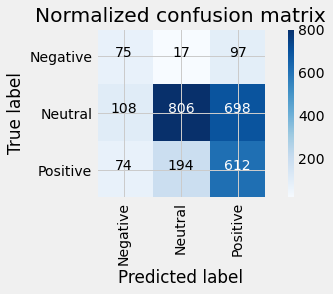

In [54]:
label_names = np.array(['Negative', 'Neutral', 'Positive'])

Probabilties = grid_RNN.predict_proba(X_test1)
cnf_matrix = confusion_matrix(np.argmax(y_test1, axis=1), np.argmax(Probabilties, axis=1))

plot_confusion_matrix("RNN",cnf_matrix, classes=np.asarray(label_names), 
                      normalize=False, title='Normalized confusion matrix')
print("\n")



RNN - Normalized confusion matrix here


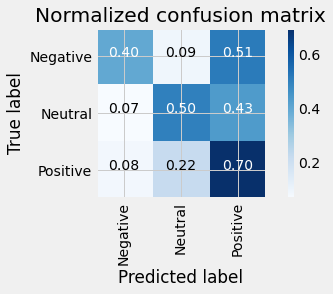

In [55]:
plot_confusion_matrix("RNN",cnf_matrix, classes=np.asarray(label_names), 
                      normalize=True, title='Normalized confusion matrix')

## Training Simple ML Models

## Bayes <a class="anchor" id="bayes"></a>

In [56]:
# tunning RNN

#____________________________________________TFIDF Data

#________Uncomment to run straight tfidf data
X_train_B = X_train_tfidf
y_train_B = y_train
X_test_B = X_test_tfidf
y_test_B = y_test
#____________________________________________

#________Uncomment to run Smoted tfidf data 
# X_train_B = X_train_sm_tfidf
# y_train_B = y_train_sm_tfidf
# X_test_B = X_test_tfidf
# y_test_B = y_test
#________
#________


#____________________________________________Pretrained Vec Data

#________Uncomment to run train test split data
# X_train_B = X_train_padded_docs
# y_train_B = y_train
# X_test_B = X_test_padded_docs
# y_test_B = y_test
#________________________________________________


hyp_params_MNB = [{'alpha':[0.01, 0.001, 0.0001]}]

clf = MultinomialNB()

grid_Bayes = GridSearchCV(estimator=clf, param_grid=hyp_params_MNB, cv=10, n_jobs=-1, return_train_score=True)
# grid_result_B  = grid_Bayes.fit(X_train_B, y_train_B)
grid_result_B  = grid_Bayes.fit(X_train_B, y_train_B, **{'sample_weight': sample_weights})

# summarize results
print("Best: %f using %s" % (grid_result_B.best_score_, grid_result_B.best_params_))
means = grid_result_B.cv_results_['mean_test_score']
stds = grid_result_B.cv_results_['std_test_score']
params = grid_result_B.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
modelscore_Train = round(grid_result_B.score(X_train_B, y_train_B),2)
modelscore_Test = round(grid_result_B.score(X_test_B, y_test_B),2)

print(f'Train Score: {modelscore_Train}')
print(f'Test Score: {modelscore_Test}')                             

Best: 0.631594 using {'alpha': 0.01}
0.631594 (0.013138) with: {'alpha': 0.01}
0.630849 (0.013684) with: {'alpha': 0.001}
0.628796 (0.014601) with: {'alpha': 0.0001}
Train Score: 0.95
Test Score: 0.64


In [57]:
print("Best score: %0.3f" % grid_result_B.best_score_)
print(f'Best Params: {grid_result_B.best_params_}')

Best score: 0.632
Best Params: {'alpha': 0.01}


### Ploting Results with Confusion Matrix <a class="anchor" id="BayesMatrix"></a>

Bayes - Confusion matrix, without normalization


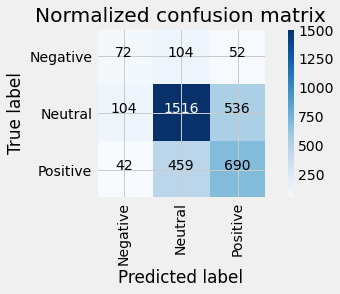

In [59]:
label_names = np.array(['Negative', 'Neutral', 'Positive'])

Probabilties = grid_Bayes.predict_proba(X_test_B)
#cnf_matrix = confusion_matrix(y_test_B, np.argmax(Probabilties, axis=1))

y_pred_B = grid_Bayes.predict(X_test_B)
cnf_matrix = confusion_matrix(y_test_B, y_pred_B)

plot_confusion_matrix("Bayes",cnf_matrix, classes=np.asarray(label_names), 
                      normalize=False, title='Normalized confusion matrix')


Bayes - Normalized confusion matrix here


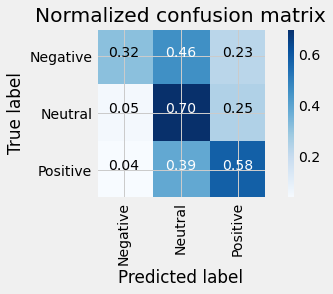

In [60]:
plot_confusion_matrix("Bayes",cnf_matrix, classes=np.asarray(label_names), 
                      normalize=True, title='Normalized confusion matrix')

In [ ]:
print(metrics.classification_report(y_test_B,y_pred_B))
print(metrics.accuracy_score(y_test,y_pred_B))

## RF <a class="anchor" id="SVMMatrix"></a>

In [61]:

# tunning RNN

#____________________________________________TFIDF Data

#________Uncomment to run straight tfidf data
X_train_RF = X_train_tfidf
y_train_RF = y_train
X_test_RF = X_test_tfidf
y_test_RF = y_test
#____________________________________________

#________Uncomment to run Smoted tfidf data 
# X_train_B = X_train_sm_tfidf
# y_train_B = y_train_sm_tfidf
# X_test_B = X_test_tfidf
# y_test_B = y_test
#________
#________


#____________________________________________Pretrained Vec Data

#________Uncomment to run train test split data
# X_train_B = X_train_padded_docs
# y_train_B = y_train
# X_test_B = X_test_padded_docs
# y_test_B = y_test
#________________________________________________

    
clf = RandomForestClassifier()
# scores = cross_val_score(clf,X_train_RF,y_train_RF,cv=5)
#print(scores)
#scores.mean()



# hyp_params_RF1 = [{
#             'clf__criterion': ['gini'],
#             'clf__max_depth': [3],
#             'clf__n_estimators': [300],
#             'clf__min_samples_split': [2],
#             'clf__min_samples_leaf':[200],
#             'clf__max_features': [.2],
#             'clf__class_weight':[{0: 5.47244094488189, 1: 0.5521716101694916, 2: 0.9938036224976168}]}]


hyp_params_RF = {
    'n_estimators': [50,100,300],
    'max_depth': [1,2,None],
    'class_weight':['balanced_subsample','balanced']
}
#balanced_subsample
#from imblearn.ensemble import BalancedRandomForestClassifier
#from imblearn.ensemble import EasyEnsembleClassifier


grid_RF = GridSearchCV(estimator=clf, param_grid=hyp_params_RF, cv=10, n_jobs=-1, return_train_score=True)
grid_result_RF  = grid_RF.fit(X_train_RF, y_train_RF)
# grid_result_RF  = grid_RF.fit(X_train_RF, y_train_RF, **{'sample_weight': sample_weights})

# summarize results
print("Best: %f using %s" % (grid_result_RF.best_score_, grid_result_RF.best_params_))
means = grid_result_RF.cv_results_['mean_test_score']
stds = grid_result_RF.cv_results_['std_test_score']
params = grid_result_RF.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
modelscore_Train = round(grid_result_RF.score(X_train_RF, y_train_RF),2)
modelscore_Test = round(grid_result_RF.score(X_test_RF, y_test_RF),2)

print(f'Train Score: {modelscore_Train}')
print(f'Test Score: {modelscore_Test}')    

Best: 0.670766 using {'class_weight': 'balanced_subsample', 'max_depth': None, 'n_estimators': 300}
0.445634 (0.074236) with: {'class_weight': 'balanced_subsample', 'max_depth': 1, 'n_estimators': 50}
0.421759 (0.054684) with: {'class_weight': 'balanced_subsample', 'max_depth': 1, 'n_estimators': 100}
0.474344 (0.028035) with: {'class_weight': 'balanced_subsample', 'max_depth': 1, 'n_estimators': 300}
0.446365 (0.060395) with: {'class_weight': 'balanced_subsample', 'max_depth': 2, 'n_estimators': 50}
0.460368 (0.063381) with: {'class_weight': 'balanced_subsample', 'max_depth': 2, 'n_estimators': 100}
0.484420 (0.024973) with: {'class_weight': 'balanced_subsample', 'max_depth': 2, 'n_estimators': 300}
0.668714 (0.016953) with: {'class_weight': 'balanced_subsample', 'max_depth': None, 'n_estimators': 50}
0.666477 (0.019831) with: {'class_weight': 'balanced_subsample', 'max_depth': None, 'n_estimators': 100}
0.670766 (0.019927) with: {'class_weight': 'balanced_subsample', 'max_depth': Non

## Plot Confusion Matrix <a class="anchor" id="SVMMatrix"></a>

RF - Confusion matrix, without normalization


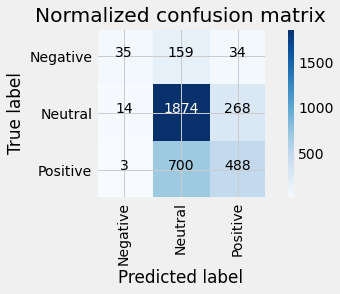

In [63]:
label_names = np.array(['Negative', 'Neutral', 'Positive'])

Probabilties_RF = grid_RF.predict_proba(X_test_RF)
#cnf_matrix = confusion_matrix(y_test_B, np.argmax(Probabilties, axis=1))

y_pred_RF = grid_RF.predict(X_test_RF)
cnf_matrix = confusion_matrix(y_test_RF, y_pred_RF)

plot_confusion_matrix("RF",cnf_matrix, classes=np.asarray(label_names), 
                      normalize=False, title='Normalized confusion matrix')

RF - Normalized confusion matrix here


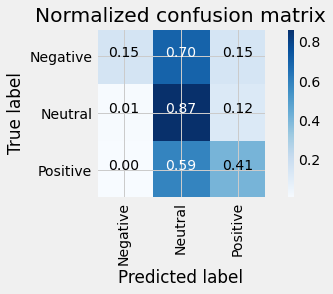

In [64]:
plot_confusion_matrix("RF",cnf_matrix, classes=np.asarray(label_names), 
                      normalize=True, title='Normalized confusion matrix')

In [65]:
print(metrics.classification_report(y_test_RF,y_pred_RF))
print(metrics.accuracy_score(y_test,y_pred_RF))

              precision    recall  f1-score   support

           0       0.67      0.15      0.25       228
           1       0.69      0.87      0.77      2156
           2       0.62      0.41      0.49      1191

    accuracy                           0.67      3575
   macro avg       0.66      0.48      0.50      3575
weighted avg       0.66      0.67      0.64      3575

0.6704895104895104


# Misc

In [ ]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [ ]:

features = X_train_B
labels = y_train_B


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])



import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [ ]:
model = LinearSVC()
# X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
# features = X_train_sm_tfidf
# labels = y_train_sm_tfidf

# .score(X_test1, y_test1)

model.fit(X_train_sm_tfidf, y_train_sm_tfidf)

y_pred = model.predict(X_test_tfidf)
print(model.score(X_train_tfidf, y_train))
print(model.score(X_test_tfidf, y_test))

# from sklearn.metrics import confusion_matrix

# conf_mat = confusion_matrix(y_test, y_pred)
# fig, ax = plt.subplots(figsize=(10,10))
# sns.heatmap(conf_mat, annot=True, fmt='d',
#             xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
# plt.ylabel('Actual')
# plt.xlabel('Predicted')
# plt.show()

In [ ]:
print(metrics.classification_report(y_test,y_pred))
print(metrics.accuracy_score(y_test,y_pred))